In [55]:
import numpy as np
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cv2
from sklearn.cluster import estimate_bandwidth 

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


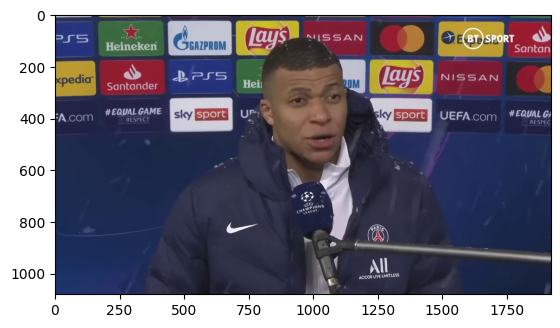

In [57]:
cap = cv2.VideoCapture('/content/drive/My Drive/csc420_a4/KylianMbappe.mp4') # camera feed

# capture one frame
ret,frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(frame)

In [167]:
def get_iou(box1, box2): 
    
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    intersec = max(0, xB - xA) * max(0, yB - yA)
    common_area = (w1*h1) + (w2*h2) - intersec
    
    # Calculate IoU and return it
    if common_area > 0:
      iou = intersec / common_area
    else:
      iou = 0
    return iou

Total frames: 75


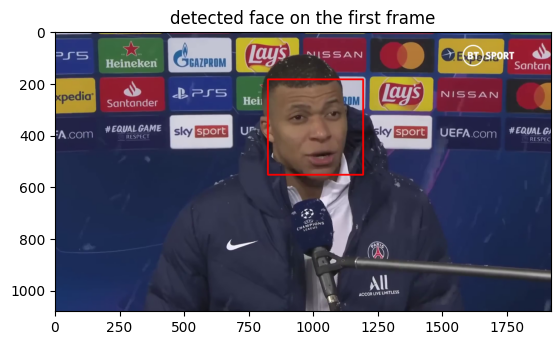

74


In [184]:
cap = cv2.VideoCapture('/content/drive/My Drive/csc420_a4/KylianMbappe.mp4') # camera feed

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Print the total number of frames
print("Total frames:", total_frames)
# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
face_boxes = face_detector.detectMultiScale(frame) 

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[0]) 
track_window = (x,y,w,h)
prev_box = (x,y,w,h)

first_frame = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)
first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
plt.imshow(first_frame)
plt.title("detected face on the first frame")
plt.show()
#  region of interest for tracking
roi = frame[y:y+h, x:x+w]

# convert the roi to HSV so we can construct a histogram of Hue 
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# why do we need this mask? (remember the cone?)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))


# form histogram of hue in the roi
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])

# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )


ious = []
larger_ious_index = []
smaller_ious_index = []
greater_than_50_count = 0
frames = []
frame_no = []
count = 1
while True:
    # grab a frame
    ret ,frame = cap.read()
    if ret == True:
        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        # display tracked window
        x1,y1,w1,h1 = track_window
        img = cv2.rectangle(frame, (x1,y1), (x1+w1,y1+h1), (0,0,255),5)

        face_boxes = face_detector.detectMultiScale(frame)
        # detector
        #print(len(face_boxes))
        temp_ious = []
        if len(face_boxes) == 0:
          pass
        else:
          
          for f_box in face_boxes:
            curr_iou = get_iou(prev_box, tuple(f_box))
            temp_ious.append(curr_iou)

          (best_x, best_y, best_w, best_h)  = tuple(face_boxes[np.argmax(temp_ious)])
          iou = get_iou(track_window, (best_x, best_y, best_w, best_h) )
          prev_box = (best_x, best_y, best_w, best_h)
          
          img = cv2.rectangle(frame, (best_x,best_y), (best_x+best_w, best_y+best_h), (0,255,0),5)
          ious.append(iou)
          frames.append(frame)
          count += 1
          frame_no.append(count)
          if iou > 0.5:
            greater_than_50_count+=1
          if iou > 0.65:
            larger_ious_index.append(count)
          elif iou < 0.5:
            smaller_ious_index.append(count)
          

          if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
    else:
        print(count)
        break
cv2.destroyAllWindows()
cap.release()

Percentage of IOUs over 0.5: 94.52054794520548




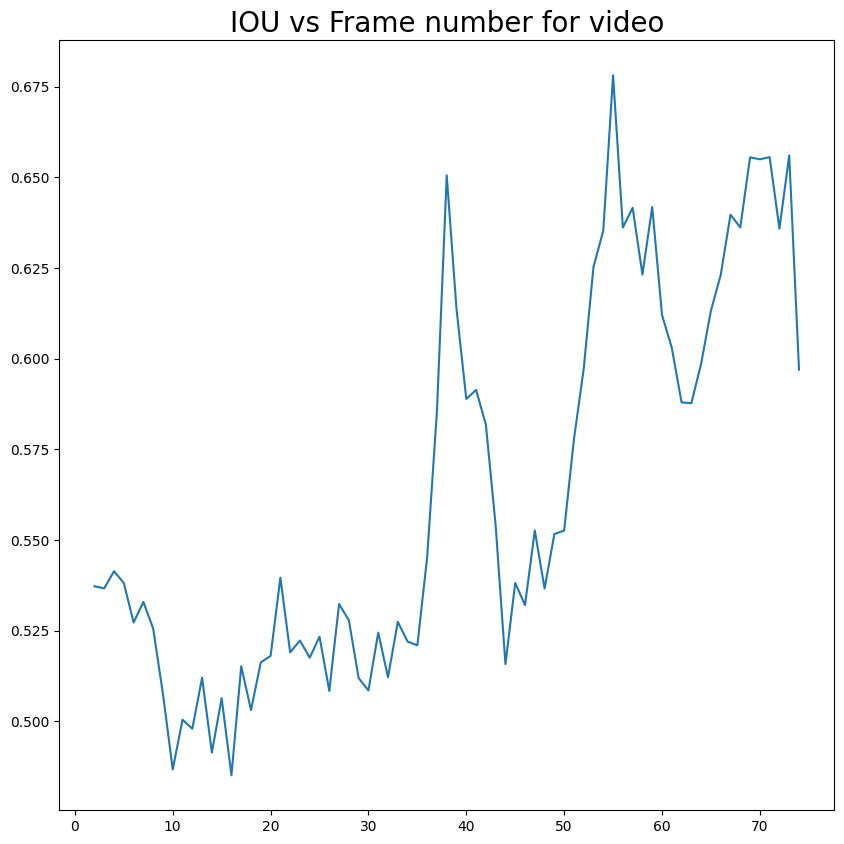

In [172]:
print("Percentage of IOUs over 0.5:", ((np.array(ious) > 0.5).mean()*100))
print("\n")
f, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(frame_no, ious)
ax.set_title("IOU vs Frame number for video")
ax.title.set_size(20)

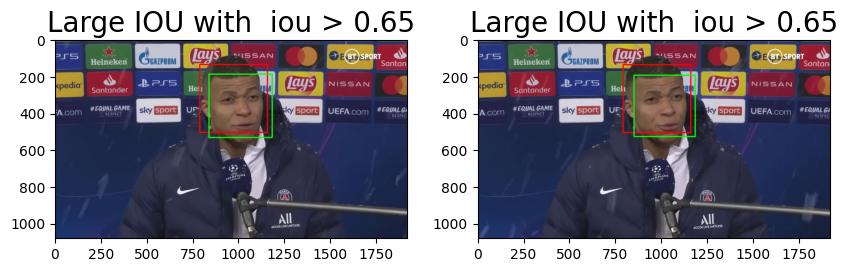

In [173]:
large_iou_1 =  cv2.cvtColor(frames[larger_ious_index[0]], cv2.COLOR_BGR2RGB)
large_iou_2 =  cv2.cvtColor(frames[larger_ious_index[3]], cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(large_iou_1)
ax[1].imshow(large_iou_2)
ax[0].set_title("Large IOU with  iou > 0.65")
ax[1].set_title("Large IOU with  iou > 0.65")
ax[0].title.set_size(20)
ax[1].title.set_size(20)


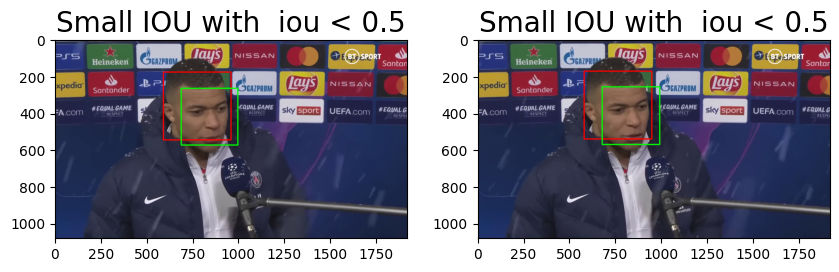

In [174]:
small_iou_1 =  cv2.cvtColor(frames[smaller_ious_index[0]], cv2.COLOR_BGR2RGB)
small_iou_2 =  cv2.cvtColor(frames[smaller_ious_index[2]], cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(small_iou_1)
ax[1].imshow(small_iou_2)
ax[0].set_title("Small IOU with  iou < 0.5")
ax[1].set_title("Small IOU with  iou < 0.5")
ax[0].title.set_size(20)
ax[1].title.set_size(20)

In [176]:
def get_histogram(img):

  gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
  gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

  mag, ang = cv2.cartToPolar(gx,gy,angleInDegrees=True)
  ang = np.array(ang, dtype=np.uint8)

  mask = cv2.inRange(mag, np.max(mag) * 0.1, np.inf)
  bins = 24
  hist = cv2.calcHist([ang], [0], mask, [bins], [0, 360])                   
  return hist

In [177]:
cap = cv2.VideoCapture('/content/drive/My Drive/csc420_a4/KylianMbappe.mp4') # camera feed

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Print the total number of frames
print("Total frames:", total_frames)
# capture one frame
ret,frame = cap.read()

# detect a face on the first frame
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
face_boxes = face_detector.detectMultiScale(frame) 

if len(face_boxes)==0:
    print('no face detected')
    assert(False)

# initialize the tracing window around the (first) detected face
(x,y,w,h) = tuple(face_boxes[0]) 
track_window = (x,y,w,h)
prev_box = (x,y,w,h)

#  region of interest for tracking
roi = frame[y:y+h, x:x+w]


gradient_hist = get_histogram(roi)


# why do we need this mask? (remember the cone?)


# normalize the histogram array values so they are in the min=0 to max=255 range
cv2.normalize(gradient_hist,gradient_hist,0,255,cv2.NORM_MINMAX)

# termination criteria for mean shift: 10 iteration or shift less than 1 pixel
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )


ious = []
larger_ious_index = []
smaller_ious_index = []
greater_than_50_count = 0
frames = []
frame_no = []
count = 1
while True:
    # grab a frame
    ret ,frame = cap.read()
    if ret == True:
        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # histogram back projection using roi_hist
        dst = cv2.calcBackProject([hsv],[0],gradient_hist,[0,180],1)
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        # display tracked window
        x1,y1,w1,h1 = track_window
        img = cv2.rectangle(frame, (x1,y1), (x1+w1,y1+h1), (0,0,255),5)

        face_boxes = face_detector.detectMultiScale(frame)
        # detector
        #print(len(face_boxes))

        temp_ious = []
        if len(face_boxes) == 0:
          pass
        else: 
          for f_box in face_boxes:
            curr_iou = get_iou(prev_box, tuple(f_box))
            temp_ious.append(curr_iou)

          (best_x, best_y, best_w, best_h)  = tuple(face_boxes[np.argmax(temp_ious)])
          iou = get_iou(track_window, (best_x, best_y, best_w, best_h) )
          prev_box = (best_x, best_y, best_w, best_h)
          
          img = cv2.rectangle(frame, (best_x,best_y), (best_x+best_w, best_y+best_h), (0,255,0),5)
          ious.append(iou)
          frames.append(frame)
          count += 1
          frame_no.append(count)
          if iou > 0.5:
            greater_than_50_count+=1
          if iou > 0.85:
            larger_ious_index.append(count)
          elif iou < 0.3:
            smaller_ious_index.append(count)
          

          if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
    else:
        print(count)
        break
cv2.destroyAllWindows()
cap.release()

Total frames: 75
75


Percentage of IOUs over 0.5: 40.54054054054054




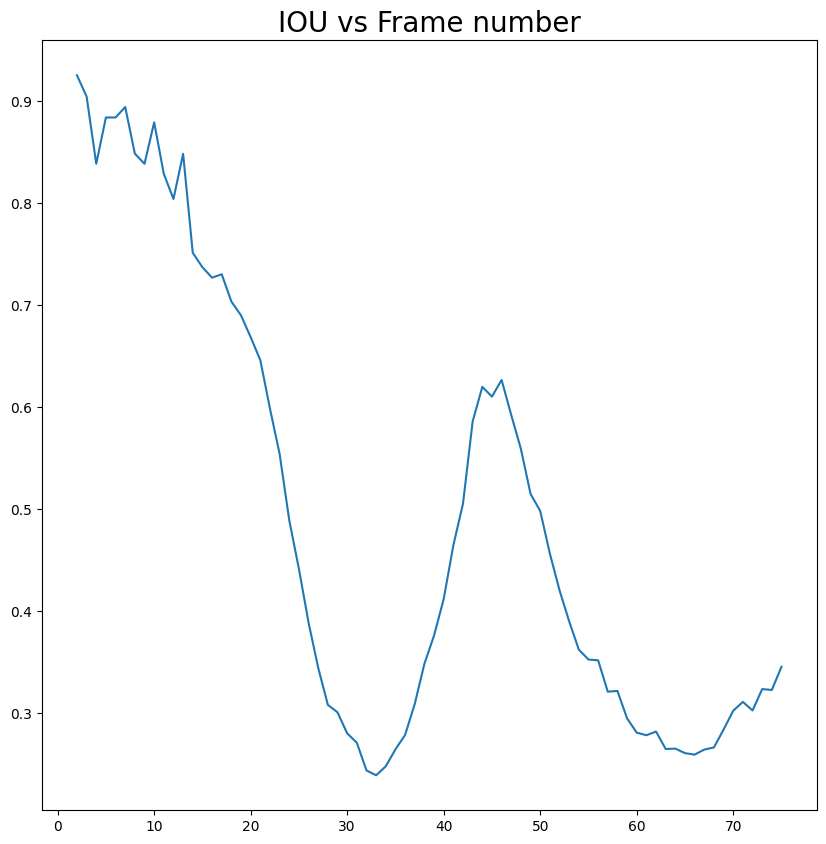

In [178]:
print("Percentage of IOUs over 0.5:", ((np.array(ious) > 0.5).mean()*100))
print("\n")
#ious.reverse()
f, ax = plt.subplots(1,1, figsize = (10, 10))
ax.plot(frame_no, ious)
ax.set_title("IOU vs Frame number")
ax.title.set_size(20)

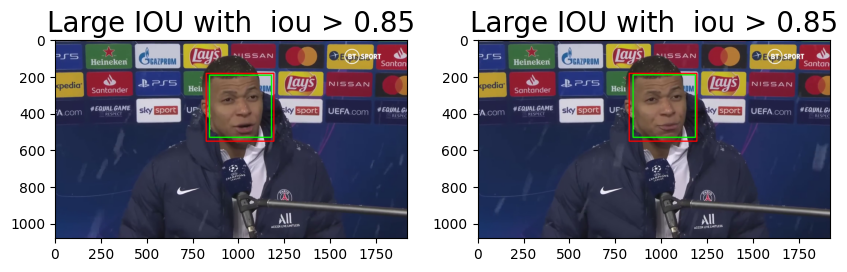

In [179]:
large_iou_1 =  cv2.cvtColor(frames[larger_ious_index[0]], cv2.COLOR_BGR2RGB)
large_iou_2 =  cv2.cvtColor(frames[larger_ious_index[3]], cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(large_iou_1)
ax[1].imshow(large_iou_2)
ax[0].set_title("Large IOU with  iou > 0.85")
ax[1].set_title("Large IOU with  iou > 0.85")
ax[0].title.set_size(20)
ax[1].title.set_size(20)


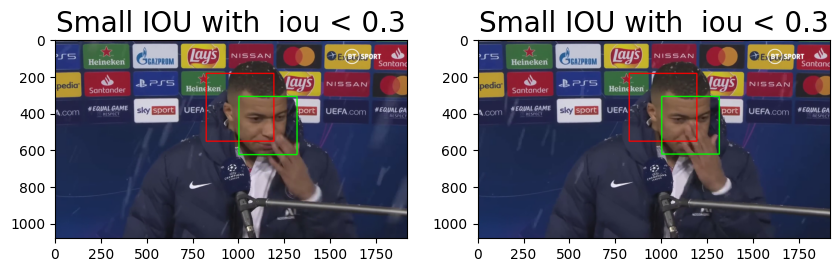

In [180]:
small_iou_1 =  cv2.cvtColor(frames[smaller_ious_index[0]], cv2.COLOR_BGR2RGB)
small_iou_2 =  cv2.cvtColor(frames[smaller_ious_index[2]], cv2.COLOR_BGR2RGB)
f, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(small_iou_1)
ax[1].imshow(small_iou_2)
ax[0].set_title("Small IOU with  iou < 0.3")
ax[1].set_title("Small IOU with  iou < 0.3")
ax[0].title.set_size(20)
ax[1].title.set_size(20)